In [44]:
# Data processing
import utils as ut
import json
import os 

# Training and validation
from sklearn.model_selection import train_test_split

# Pre-processing
from PIL import Image

# model
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image


## Pre Processing images

In [45]:
# I think we have enought images, if not we do image augmentation
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_dataset = image.ImageDataGenerator(rescale=1/255)

In [46]:
train_generator = train_datagen.flow_from_directory(
    'data\\train\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

test_generator = test_dataset.flow_from_directory(
    'data\\test\\',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
    )

Found 19486 images belonging to 2 classes.
Found 9599 images belonging to 2 classes.


In [47]:
train_generator.class_indices

{'live': 0, 'spoof': 1}

## Model 

In [48]:
# Using as a base model
# https://medium.com/@mayankverma05032001/binary-classification-using-convolution-neural-network-cnn-model-6e35cdf5bdbb

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation='ReLU', input_shape=(224,224, 3))) # Need to check the mean size of the pictures for better performance

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='ReLU'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='ReLU'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [49]:
steps = train_generator.samples / train_generator.batch_size
steps = round(steps)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps,
    epochs = 10,
    validation_data = train_generator,
    validation_steps = 2
)

C:\Users\PLour\AppData\Local\Temp\ipykernel_24628\997868978.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
609/609 [==============================] - 1959s 3s/step - loss: 0.5553 - accuracy: 0.7320 - val_loss: 0.3313 - val_accuracy: 0.8750
Epoch 2/10
609/609 [==============================] - 2112s 3s/step - loss: 0.3882 - accuracy: 0.8302 - val_loss: 0.2877 - val_accuracy: 0.8750
Epoch 3/10
609/609 [==============================] - 3314s 5s/step - loss: 0.3475 - accuracy: 0.8658 - val_loss: 0.2421 - val_accuracy: 0.9375
Epoch 4/10
609/609 [==============================] - 3301s 5s/step - loss: 0.3043 - accuracy: 0.8836 - val_loss: 0.2494 - val_accuracy: 0.9375
Epoch 5/10
609/609 [==============================] - 3369s 6s/step - loss: 0.2998 - accuracy: 0.8843 - val_loss: 0.2384 - val_accuracy: 0.9062
Epoch 6/10
609/609 [==============================] - 3363s 6s/step - loss: 0.2769 - accuracy: 0.8932 - val_loss: 0.1451 - val_accuracy: 0.9531
Epoch 7/10
609/609 [==============================] - 3124s 5s/step - loss: 0.2639 - accuracy: 0.9006 - val_loss: 0.1576 - val_accuracy:

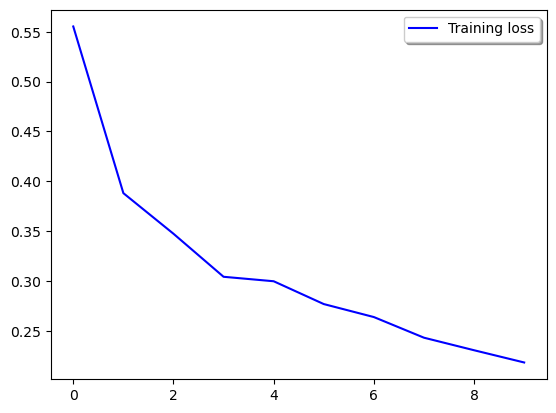

In [50]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt
import joblib


plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)



In [51]:
model.evaluate(test_generator)

300/300 [==============================] - 809s 3s/step - loss: 0.1939 - accuracy: 0.9306


[0.1938888430595398, 0.9306177496910095]

In [52]:
# save the model to disk
filename = 'models/CNN.keras'
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save(filename)



In [53]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(filename)


try:
    np.testing.assert_allclose(
        model.predict(test_generator), reconstructed_model.predict(test_generator)
    )
except Exception as e:
    print(e)

300/300 [==============================] - 342s 1s/step

Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 9597 / 9599 (100%)
Max absolute difference: 0.9999995
Max relative difference: 1.1947927e+18
 x: array([[0.999711],
       [0.999842],
       [0.023464],...
 y: array([[0.991273],
       [0.783275],
       [0.394276],...
